In [1]:
from cntools.datasets import Dataset
from general import cns_remap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import pickle
from matplotlib.lines import Line2D
from general import catplot, conplot
import sys
sys.path.insert(0, '..')
plt.rcParams["font.family"] = 'Arial'

In [2]:
# HLT
ds = pickle.load(open('../data/HLT/HLT_ds.pkl', 'rb'))
n_cns = 11

# Uncomment one of these results on HLT

# cns = cns_remap(pickle.load(open('../cn/HLT/CC/cns_n_cns=11_m=20_naive.pkl', 'rb')), [6, 1, 3, 2, 9, 5, 0, 8, 4, 10, 7])
# ind = ['cnGr: Granulocyte enriched', 'cnBT: B & T cell enriched', 'cnMph: Macrophage enriched', 'cnT: T cell enriched', 'cnV: Blood vessel', 'cnB: B cell enriched', 'cnTsp: Tetraspanin positive cell enriched', 'cnVT: Blood vessel & T cell enriched', 'cnEp: Epithelial cell enriched', 'cnDZ: Dark zone', 'cnLZ: Light zone']

# cns = cns_remap(pickle.load(open('../cn/HLT/CF-IDF/cns_n_cns=11_eps=23_r=0.8_naive.pkl', 'rb')), [2, 9, 10, 3, 8, 4, 5, 0, 7, 6, 1])
# ind = ['cnGr: Granulocyte enriched', 'cnGrMph: Granulocyte & macrophage enriched', 'cnMph: Macrophage enriched', 'cnT: T cell enriched', 'cnV: Blood vessel', 'cnB: B cell enriched', 'cnTsp: Tetraspanin positive cell enriched', 'cnPl: Plasma cell enriched', 'cnEp: Epithelial cell enriched', 'cnLZDZ: Light & dark zone', 'cnMphNK: Macrophage & NK cell enriched']

cns = cns_remap(pickle.load(open('../cn/HLT/CNE/cns_n_cns=11_perp=15_lam=0.25_naive.pkl', 'rb')), [1, 6, 2, 8, 9, 4, 7, 5, 3, 10, 0])
ind = ['cnGr: Granulocyte enriched', 'cnBT: B & T cell enriched', 'cnMph: Macrophage enriched', 'cnT: T cell enriched', 'cnV: Blood vessel', 'cnB: B cell enriched', 'cnTsp: Tetraspanin positive cell enriched', 'cnPl: Plasma cell enriched', 'cnEp: Epithelial cell enriched', 'cnDZ: Dark zone', 'cnLZ: Light zone']

In [3]:
l =  [str(i) for i in range(n_cns)]
lmap = {j:i for i,j in enumerate(l)}
palt = {str(i):j for i,j in enumerate(sns.color_palette('bright', 10) + [(0, 0, 0)])}

In [4]:
w = []
for sample in ds.data:
    for image in ds.data[sample]:
        locs = ds.data[sample][image].locs
        _, indices = NearestNeighbors(n_neighbors=100).fit(locs).kneighbors(locs)
        cns_nbs = cns[sample][image][indices]
        w_tmp = np.zeros((len(locs), len(l)))
        for i in range(len(cns_nbs)):
            for j in range(len(cns_nbs[0])):
                w_tmp[i][cns_nbs[i][j]] += 1
        w.append(w_tmp)
w = pd.DataFrame(np.concatenate(w), columns=l)

In [5]:
# '''
# this code samples the GC CNs and projects them into barycentric coordinates
# '''
# # w = pd.read_pickle('cn_windows_50thru1000/100_windows')
# wgc  = w.loc[w.loc[:,['LZ','DZ','5']].sum(axis=1)>90,:]
# idx = wgc.index.values
# x = wgc.loc[:,['LZ','DZ','5']]
# proj = np.array([[0,0],[np.cos(np.pi/3),np.sin(np.pi/3)], [1,0]])
# coords = np.dot(x/100,proj)

In [6]:
# figsize(7,7)
# jit = .002
# cols = [palt[a] for a in wgc['NEIGH_newGC']]
# plt.scatter(coords[:,0]+jit*np.random.randn(len(coords)),coords[:,1]+jit*np.random.randn(len(coords)),s = 2,alpha = .5, c = cols)
# plt.axis('off')

In [7]:
# '''
# this code does the same with the T cell zone CNs
# '''
# wgc  = w.loc[w.loc[:,['1','3','4']].sum(axis=1)>90,:].sample(n = 80000)
# idx = wgc.index.values
# x = wgc.loc[:,['1','3','4']]
# proj = np.array([[0,0],[np.cos(np.pi/3),np.sin(np.pi/3)], [1,0]])
# coords = np.dot(x/100,proj)

# figsize(7,7)
# jit = .002
# cols = [palt[a] for a in wgc['NEIGH_newGC']]
# plt.scatter(coords[:,0]+jit*np.random.randn(len(coords)),coords[:,1]+jit*np.random.randn(len(coords)),s = 2,alpha = .5, c = cols)
# plt.axis('off')

In [8]:
'''
this is the code that finds the minimal combination of CNs
required to make up a threshold percentage of assignments in a window
combinations are stored as a sorted tuple
'''
def get_thresh_simps(x,thresh):
    sorts = np.argsort(-x, axis = 1)
    x_sorted = -np.sort(-x, axis = 1)
    cumsums = np.cumsum(x_sorted,axis = 1)
    thresh_simps = pd.Series([tuple(sorted(sorts[i,:(1+j)])) for i,j in enumerate(np.argmax(cumsums>thresh,axis = 1))])
    return thresh_simps

In [9]:
# w = pd.read_pickle('cn_windows_50thru1000/100_windows')
x = w.loc[:,l].values/100

In [10]:
# w['combination'] = [tuple(l[a] for a in s) for s in simps]

In [11]:
# w.to_pickle('windows100_with_combinations')

In [12]:
simps = get_thresh_simps(x,.9)
simp_freqs = simps.value_counts(normalize = True)
simp_sums = np.cumsum(simp_freqs)

([<matplotlib.axis.XTick at 0x7f8f7018fbe0>,
 [Text(0, 0, '0'),
  Text(10, 0, '10'),
  Text(20, 0, '20'),
  Text(30, 0, '30'),
  Text(40, 0, '40'),
  Text(50, 0, '50'),
  Text(60, 0, '60'),
  Text(70, 0, '70'),
  Text(80, 0, '80'),
  Text(90, 0, '90'),
  Text(100, 0, '100'),
  Text(110, 0, '110'),
  Text(120, 0, '120'),
  Text(130, 0, '130'),
  Text(140, 0, '140'),
  Text(150, 0, '150'),
  Text(160, 0, '160'),
  Text(170, 0, '170'),
  Text(180, 0, '180'),
  Text(190, 0, '190'),
  Text(200, 0, '200'),
  Text(210, 0, '210'),
  Text(220, 0, '220'),
  Text(230, 0, '230'),
  Text(240, 0, '240'),
  Text(250, 0, '250'),
  Text(260, 0, '260'),
  Text(270, 0, '270'),
  Text(280, 0, '280'),
  Text(290, 0, '290'),
  Text(300, 0, '300'),
  Text(310, 0, '310'),
  Text(320, 0, '320'),
  Text(330, 0, '330'),
  Text(340, 0, '340'),
  Text(350, 0, '350'),
  Text(360, 0, '360'),
  Text(370, 0, '370'),
  Text(380, 0, '380'),
  Text(390, 0, '390'),
  Text(400, 0, '400'),
  Text(410, 0, '410'),
  Text(420,

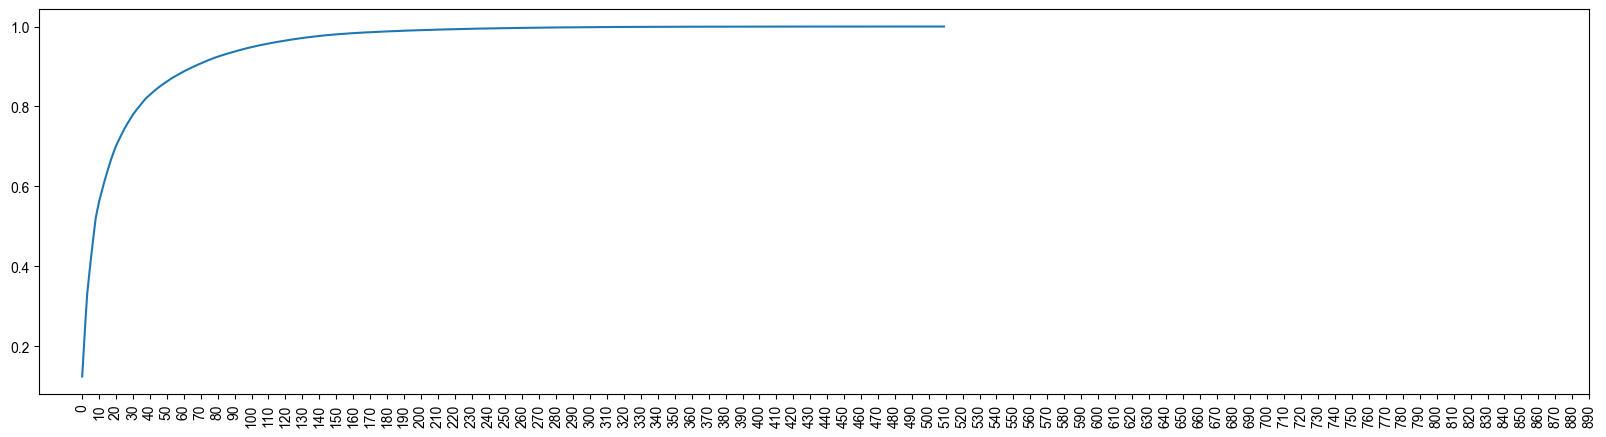

In [13]:
# this shows what proportion (y) of the total cells are assigned to the top x combinations
plt.figure(figsize=(20,5))
plt.plot(simp_sums.values)
plt.xticks(range(0,900,10),range(0,900,10),rotation = 90,fontsize = 10)

The following plots show that we start missing out some important bits when we cut the number of combinations we visualise

In [14]:
# selected_cells = simps[simps.isin(simp_sums[simp_sums<=.99].index.values)]
# catplot(w.loc[selected_cells.index.values],hue = 'NEIGH_newGC',palette = palt,figsize =10)

In [15]:
# selected_cells = simps[simps.isin(simp_sums[simp_sums<=.9].index.values)]
# catplot(w.loc[selected_cells.index.values],hue = 'NEIGH_newGC',palette = palt,figsize =10)

In [16]:
# selected_cells = simps[simps.isin(simp_sums[simp_sums<=.95].index.values)]
# catplot(w.loc[selected_cells.index.values],hue = 'NEIGH_newGC',palette = palt,figsize =10)

We appear to gain some systematic bias by taking only those simplices up to .9 in sum. .95 seems a little better, but the tradeoff is between what the graph looks like at .95 and .99.

In [17]:
# selected_cells = simps[simps.isin(simp_sums[simp_freqs>=.001].index.values)]
# catplot(w.loc[selected_cells.index.values],hue = 'NEIGH_newGC',palette = palt,figsize =10)

In [18]:
g = nx.DiGraph()
thresh_cumulative = .99
thresh_freq = .001
#selected_simps = simp_sums[simp_sums<=thresh_cumulative].index.values
selected_simps = simp_freqs[simp_freqs>=thresh_freq].index.values

In [19]:
'''
this builds the graph for the CN combination map
'''
for e0 in selected_simps:
    for e1 in selected_simps:
        if (set(list(e0))<set(list(e1))) and (len(e1) == len(e0)+1):
            g.add_edge(e0,e1)

In [20]:
tops = simp_freqs[simp_freqs>=thresh_freq].sort_values(ascending = False).index.values.tolist()[:20]

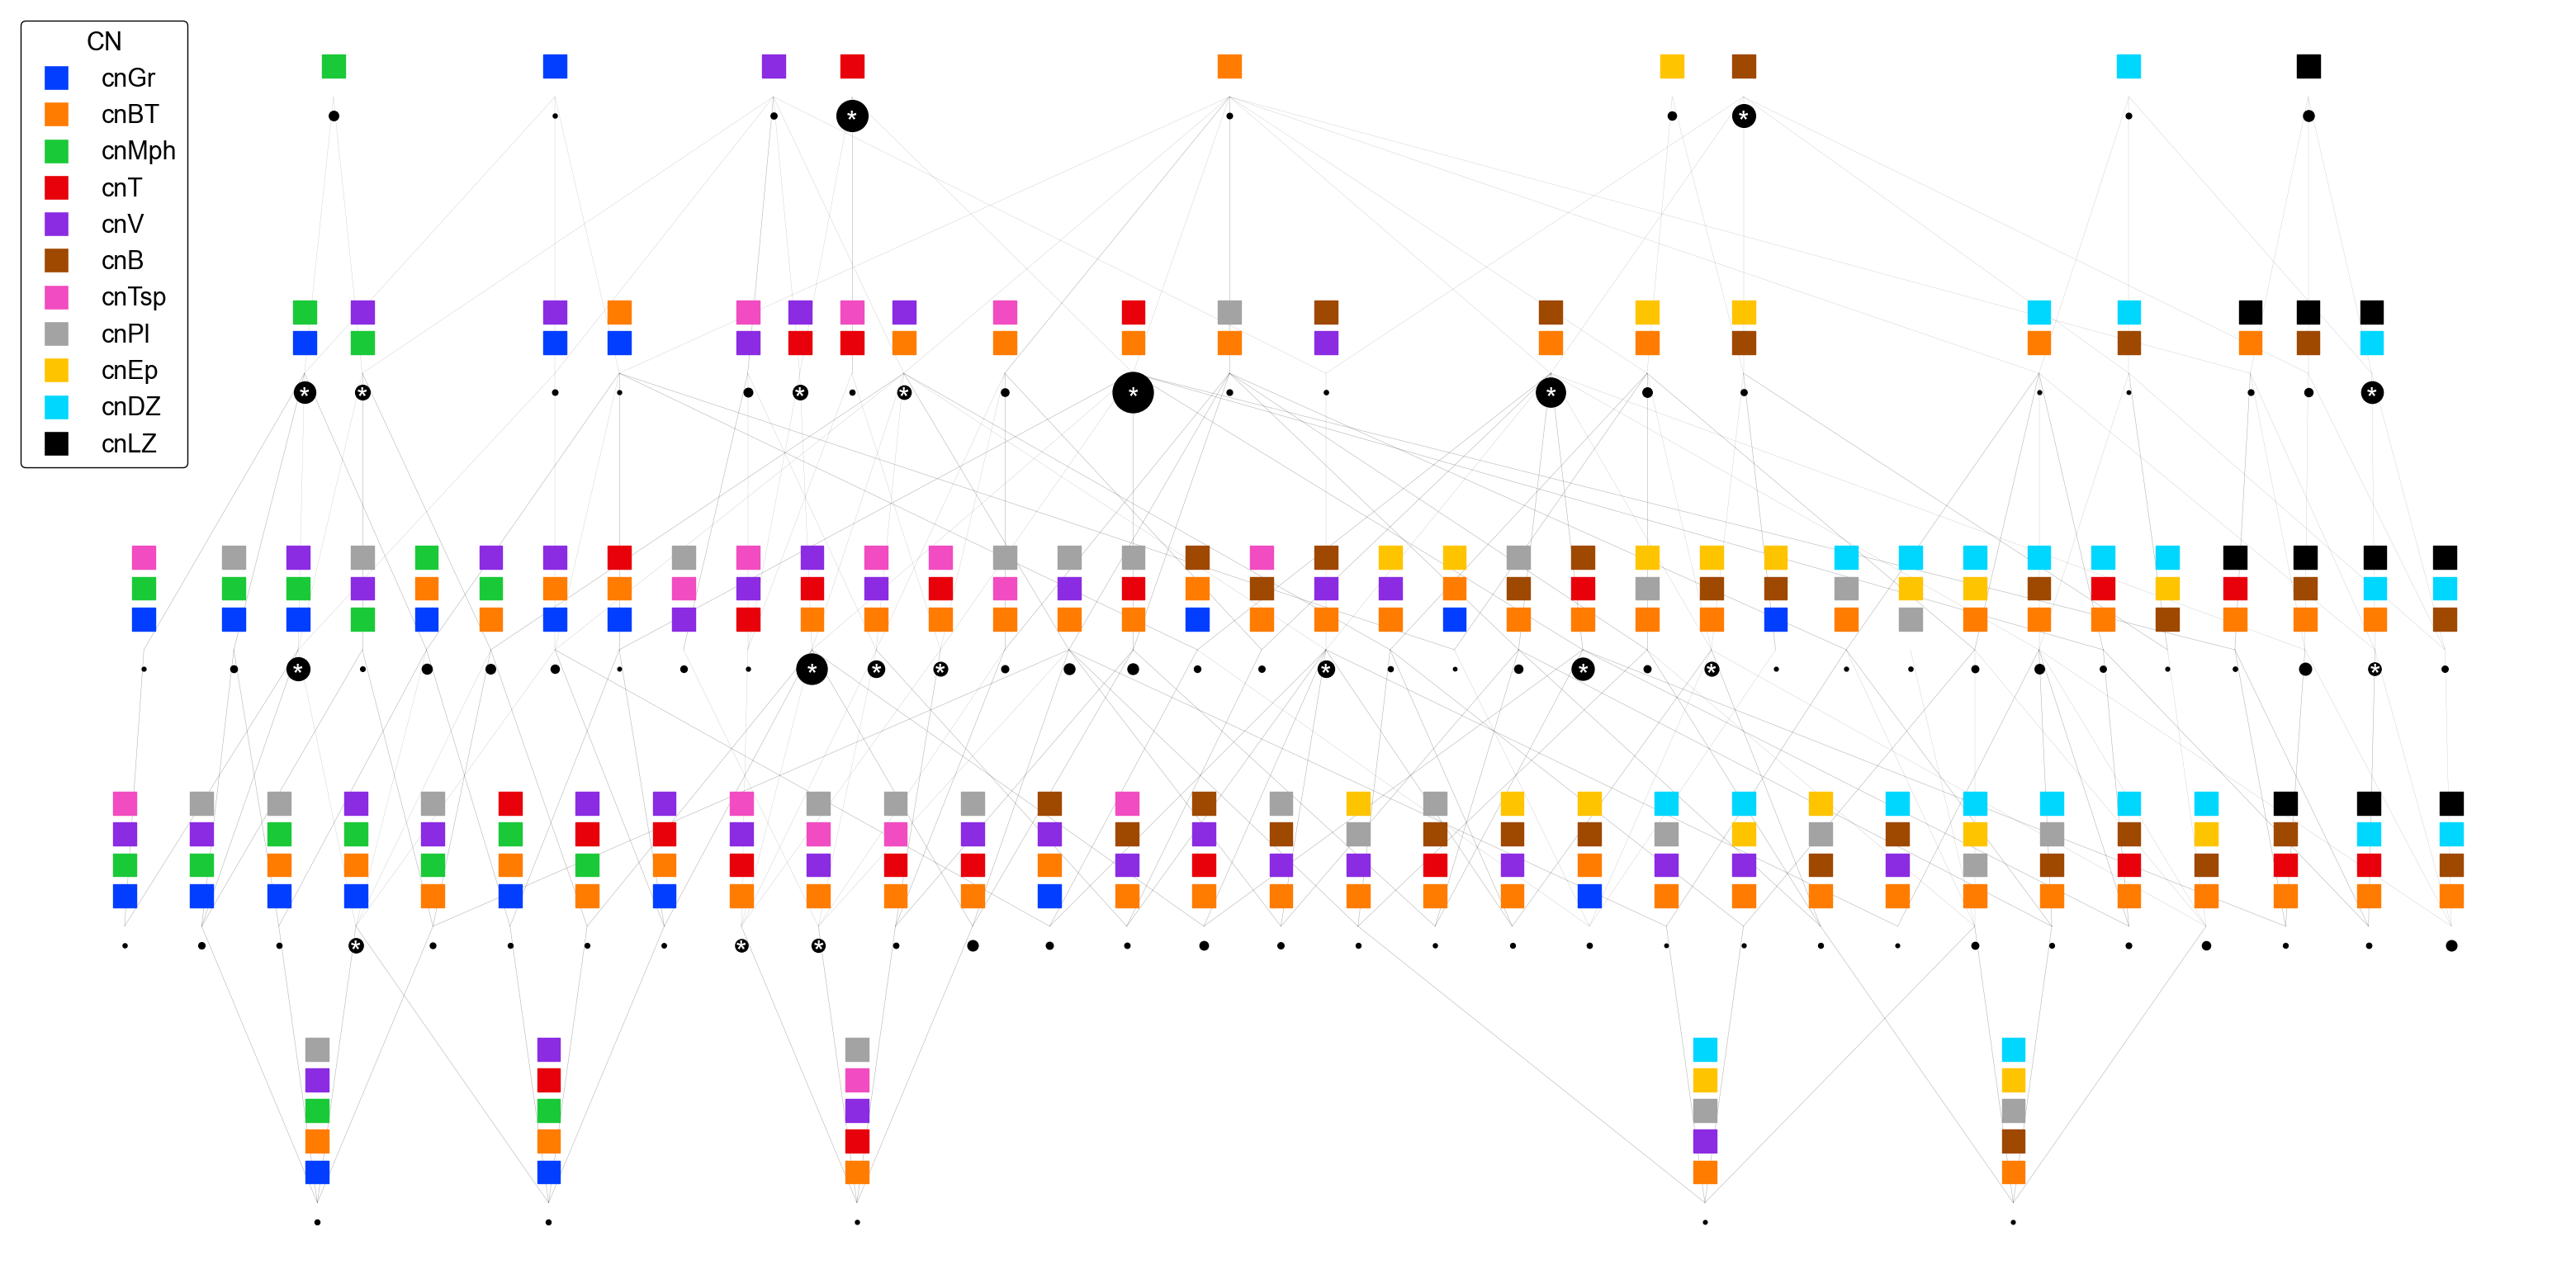

In [21]:
'''
this plots the CN combination map
'''
draw = g
pos = nx.drawing.nx_pydot.graphviz_layout(draw, prog='dot')


plt.figure(figsize=(40,20))
for n in draw.nodes():
    col = 'black'
    if len(draw.in_edges(n))<len(n):
        col = 'black'
    plt.scatter(pos[n][0],pos[n][1]-5, s = simp_freqs[n]*10000, c = col, zorder = -1)
    if n in tops:
        plt.text(pos[n][0],pos[n][1]-7, '*', fontsize = 25, color = 'white', ha = 'center', va = 'center',zorder = 20)
    delta = 8
    #plot_sim((pos[n][0]+delta, pos[n][1]+delta),n, scale = 20,s = 200,text = True,fontsize = 15)
    h = plt.scatter([pos[n][0]]*len(n),[pos[n][1]+delta*(i+1) for i in range(len(n))],c = [palt[l[i]] for i in n] ,marker = 's', zorder = 5,s = 400)
    
        
j = 0
for e0,e1 in draw.edges():
    color = 'black'
    weight = 0.2
    alpha = .3
    if len(draw.in_edges(e1))<len(e1):
        color = 'black'
        lw =1
        weight = 0.4
    plt.plot([pos[e0][0], pos[e1][0]],[pos[e0][1], pos[e1][1]], color = color, linewidth = weight,alpha = alpha,zorder = -10)

legend = plt.legend(handles=[Line2D([0], [0], marker='s', color='w', label='Scatter',
                          markerfacecolor=c, markersize=22) for c in palt.values()], labels=[i.split(':')[0] for i in ind], title='CN', loc='best', frameon=True, framealpha=1, edgecolor='k', title_fontsize=22, fontsize=22)

plt.axis('off')
plt.savefig('../analysis_res/HLT/CNE/CNM.pdf', bbox_inches='tight')
plt.show()